In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from feature_engine.outliers import Winsorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif

In [2]:
tb = pd.read_csv('../data/../data/train.csv', index_col='id')
tb_data = tb.sample(n=50000, random_state=16)
tb_s1 = tb.sample(n=50000, random_state=32)
tb_s2 = tb.sample(n=50000, random_state=64)

In [3]:
feature_eng = Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr',
                                                      tail='both')),
                              ('power', PowerTransformer()),
                              ('range', MinMaxScaler())])
feature_eng.get_params()

{'memory': None,
 'steps': [('outliers', Winsorizer(capping_method='iqr', tail='both')),
  ('power', PowerTransformer()),
  ('range', MinMaxScaler())],
 'verbose': False,
 'outliers': Winsorizer(capping_method='iqr', tail='both'),
 'power': PowerTransformer(),
 'range': MinMaxScaler(),
 'outliers__capping_method': 'iqr',
 'outliers__fold': 3,
 'outliers__missing_values': 'raise',
 'outliers__tail': 'both',
 'outliers__variables': None,
 'power__copy': True,
 'power__method': 'yeo-johnson',
 'power__standardize': True,
 'range__clip': False,
 'range__copy': True,
 'range__feature_range': (0, 1)}

In [4]:
tb_data_fe = pd.DataFrame(feature_eng.fit_transform(tb_data.loc[:, :'f99']), columns=tb_data.columns[:100])
tb_s1_fe = pd.DataFrame(feature_eng.fit_transform(tb_s1.loc[:, :'f99']), columns=tb_data.columns[:100])
tb_s2_fe = pd.DataFrame(feature_eng.fit_transform(tb_s2.loc[:, :'f99']), columns=tb_data.columns[:100])

In [5]:
tb_data_Y = tb_data['target']
tb_s1_Y = tb_s1['target']
tb_s2_Y = tb_s2['target']

In [6]:
# feature selection

forest = RandomForestClassifier(n_estimators=200,
                                max_depth=24,
                                min_samples_split=100,
                                min_samples_leaf=50,
                                n_jobs=-1)
forest_fits = []
samples = [tb_data_fe, tb_s1_fe, tb_s2_fe]
ys = [tb_data_Y, tb_s1_Y, tb_s2_Y]

for i in range(len(samples)):
    temp = forest.fit(samples[i], ys[i])
    forest_fits.append(temp.feature_importances_)

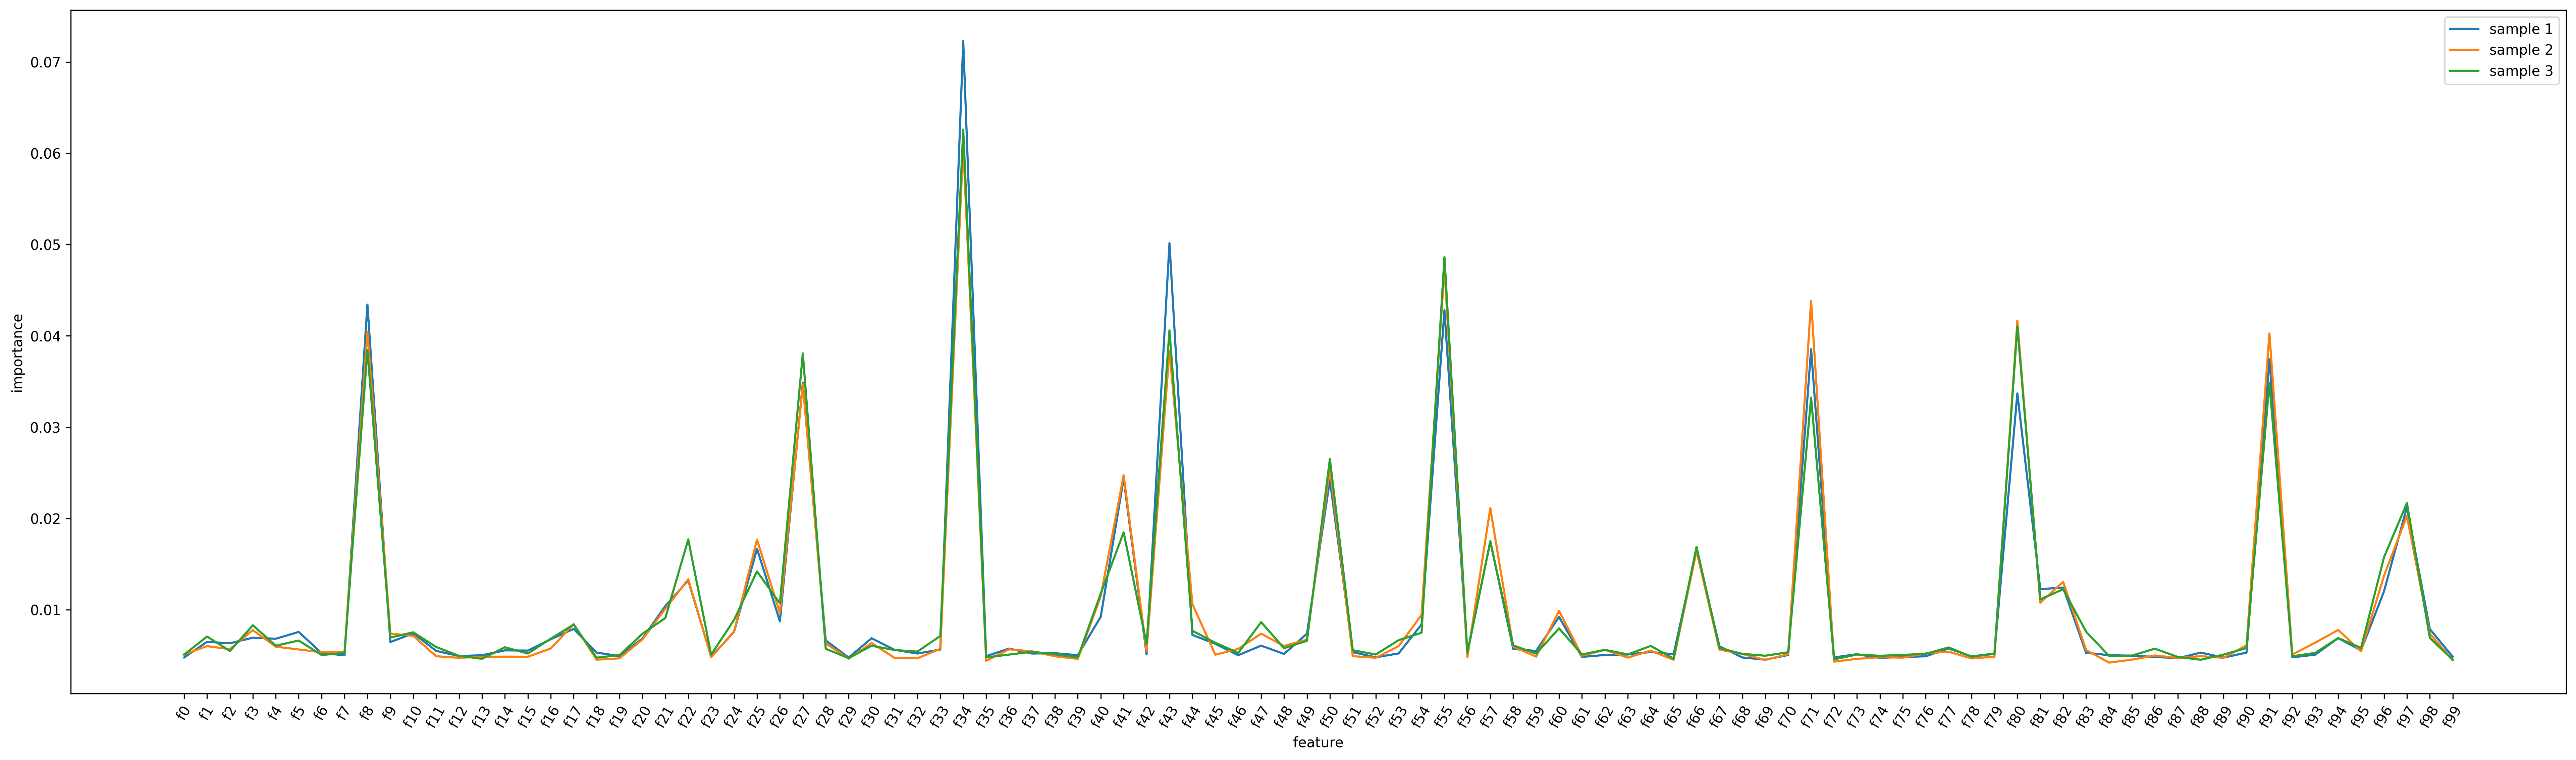

In [7]:
plt.figure(figsize=[32, 9], dpi=300)
sns.lineplot(x=tb_data.columns[:100], y=forest_fits[0], label='sample 1')
sns.lineplot(x=tb_s1.columns[:100], y=forest_fits[1], label='sample 2')
sns.lineplot(x=tb_s2.columns[:100], y=forest_fits[2], label='sample 3')
plt.xticks(rotation=60)
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

In [14]:
rfecv = RFECV(estimator=forest, step=0.1, cv=6, n_jobs=-1, scoring="accuracy")
rfecv_fits = []

for i in range(len(samples)):
    temp_rfecv = rfecv.fit(samples[i], ys[i])
    rfecv_fits.append(temp_rfecv.cv_results_)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


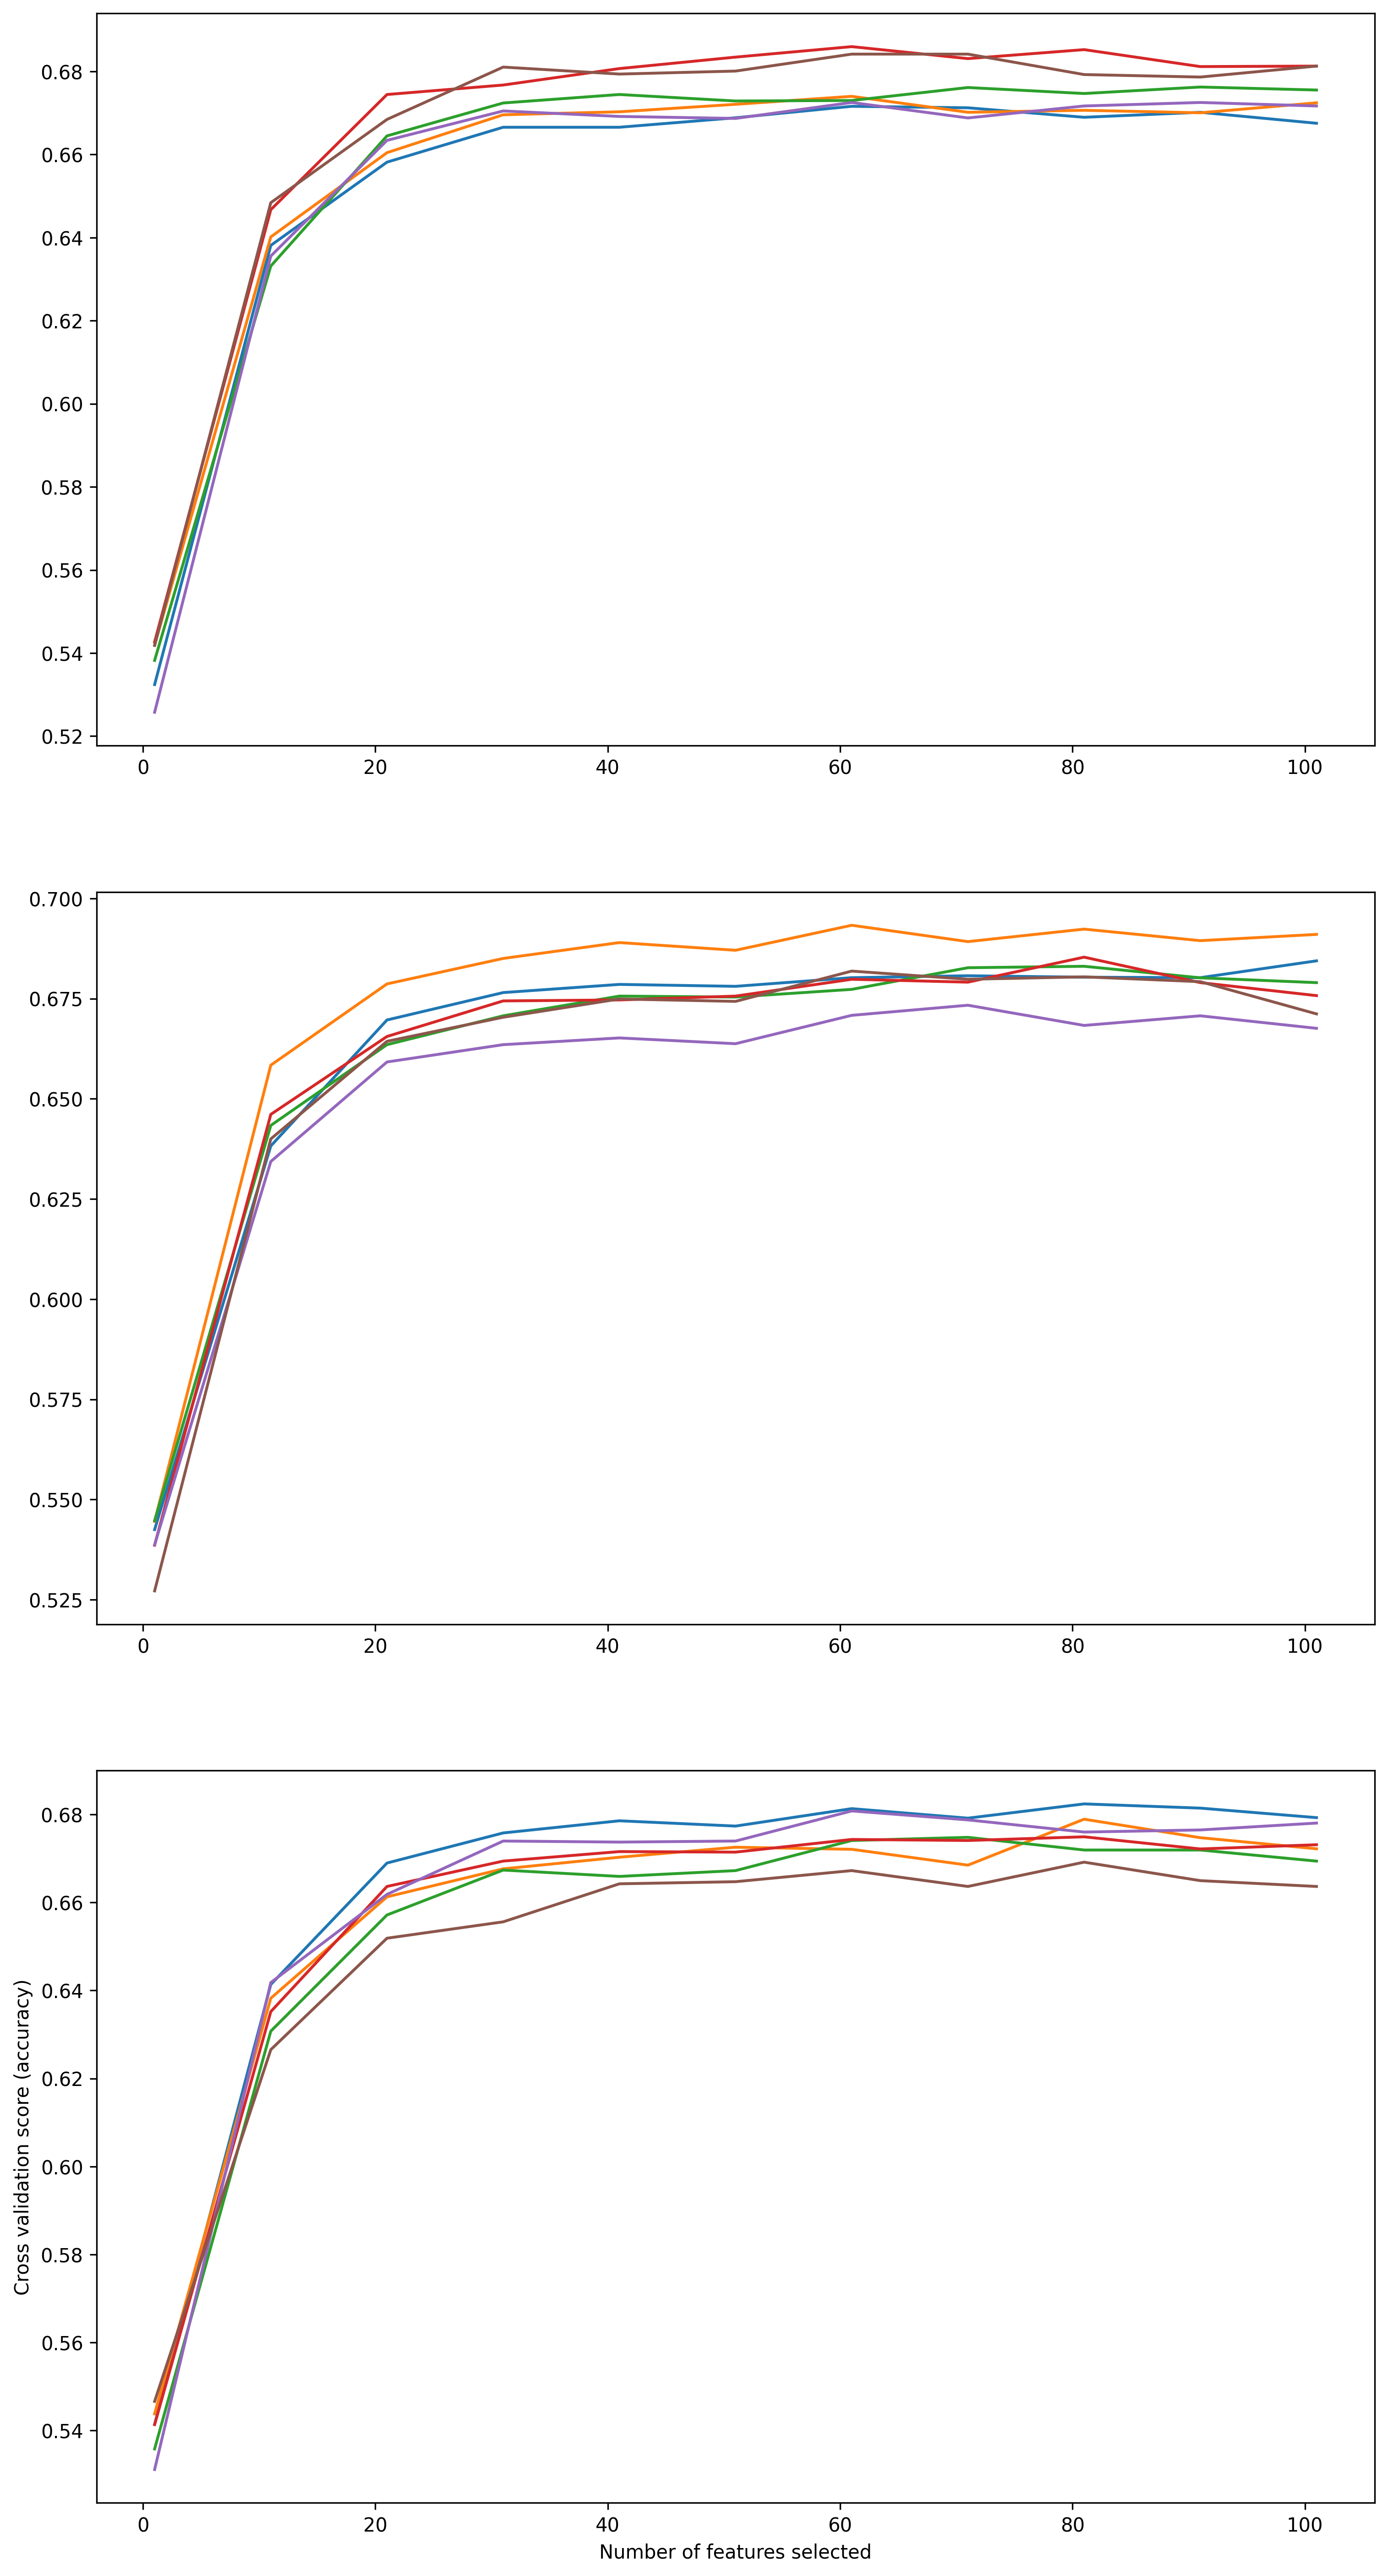

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[12, 24], dpi=300)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")

for i in range(3):
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split0_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split1_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split2_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split3_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split4_test_score'], ax=axes[i])
    sns.lineplot(x=list(range(1, 110, 10)), y=rfecv_fits[i]['split5_test_score'], ax=axes[i])

plt.show()

In [29]:
print(f'Optimal number of features can use in models: {temp_rfecv.n_features_}')

Optimal number of features can use in models: 80
